# Utrecht

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from timeit import default_timer as timer

import scipy.io

from serendipyty.seismic.modelling import awe2d
from serendipyty.seismic.modelling.bcs import PmlBc

from serendipyty.seismic.utils.util import ricker
from serendipyty.seismic.utils.fd import stability
from serendipyty.seismic.utils.fd import dispersion
from serendipyty.seismic.utils.util import rectangle
from serendipyty.seismic.utils.util import oneface

from serendipyty.seismic.utils.dispersion import itdt3
from serendipyty.seismic.input.wavelets import RickerWavelet
from serendipyty.seismic.input.sources import PointSource
from serendipyty.seismic.model.models import AcousticModel
from serendipyty.seismic.hpc.hpc import BaseHpc

from joblib import Parallel, delayed
import multiprocessing

import sys

#sys.dont_write_bytecode = True

DTYPE = np.float64

#if __name__ == '__main__':

import matplotlib as mpl
#mpl.rc('image', interpolation='none', origin='lower', cmap = 'gray')
mpl.rc('image', interpolation='none')
plt.rcParams['figure.figsize'] = 10, 8
#plt.rcParams['figure.figsize'] = 45, 30
plt.rcParams['font.size'] = 14

## Parameters

In [2]:
# Extent in # of cells
nx = 201
nz = 101

# Sampling in m
dx = DTYPE(5)
dz = DTYPE(5)

# Source in grid point locations
src_loc = np.array([600/dx, 0, 250/dx], dtype=np.uint)

# Source
sourcetype = 'q'
# Central frequency
fc = np.float64(30)

# PML
npml = 30

bc = PmlBc(npml=npml, freesurface=False)

## Model building

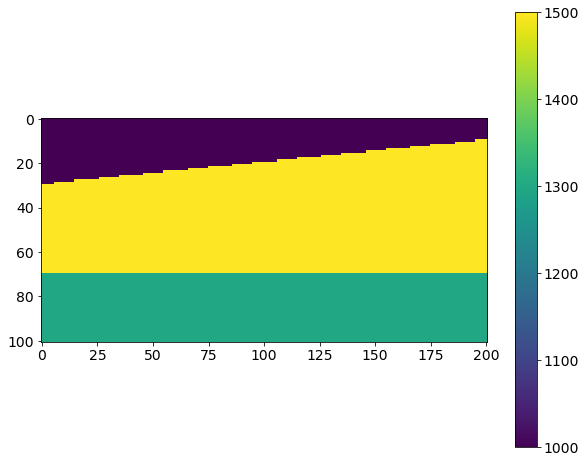

In [3]:
vp0 = 2000
rho0 = 1000

vp = np.ones((nx, nz), dtype=DTYPE)*vp0
rho = np.ones((nx, nz), dtype=DTYPE)*rho0

x = np.arange(nx)*dx
z = np.arange(nz)*dz

dip = 0.1

inta = (-dip)*x + 150.0

mask = np.zeros((nx,nz), dtype=np.bool)
for i in range(nx):
    mask[i, np.rint(inta[i]/dx).astype(int):] = True

vp[mask] = 2500
rho[mask] = 1500

intb = 350
vp[:,np.rint(intb/dx).astype(int):] = 2300
rho[:,np.rint(intb/dx).astype(int):] = 1300

fig = plt.figure(facecolor='w', edgecolor='k') #, figsize=(10,12))
plt.imshow(rho.T) #, extent=[0, x[-1], z[-1], 0])
plt.colorbar()

model = AcousticModel(dx, vp=vp, rho=rho)

In [4]:
model.n

[201, 1, 101]

## Dispersion and Stability

In [5]:
dx_no_dispersion = dispersion(vp.min(), dx, fc, coeff=2.0)
print('dx_no_dispresion is ', dx_no_dispersion)

# Time
tmax = 10.42
dt = np.float64(0.001)

# I compute the stability criterion
dt_stable = stability(vp.max(), dx, dt)
print('dt_stable is ', dt_stable)

# For this example, I keep dt (and nt) fixed
#dt = dt_stable
nt = int(tmax/dt)+1

t = np.arange(nt)*dt

dx_no_dispresion is  5.55555555556
dt_stable is  0.00141421356237


## Source wavelet

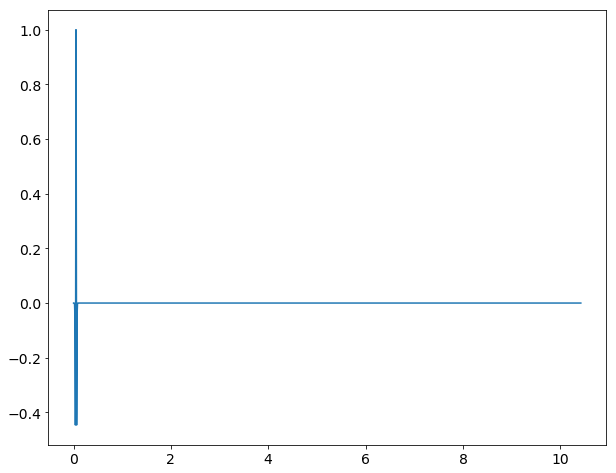

In [6]:
q_src = ricker(fc, nt, dt)

wav = RickerWavelet(t, fc=fc, delay=0.05)
src = PointSource(src_loc, wav, 'q')

plt.plot(t, wav.wavelet)

In [7]:
model.n[1]

1

## Receivers

In [8]:
# Number of disjoint subdomains
nsub = 1
semt_origins = np.ndarray((nsub, 4), dtype=np.uint)
srec_origins = np.ndarray((nsub, 4), dtype=np.uint)

# order: xemt1 xemt2 zemt1 zemt2
#semt_origins[0,:] = (40,  80,  40,  60)
#semt_origins[1,:] = (120, 160,  10,  30)
# order: xemt zemt nxemt nzemt
semt_origins[0,:] = (0,  35,  nx,  nz-35)

# number of gridpoints between recording and emitting surface
ngpts = 2

srec_origins = semt_origins + np.array((0, ngpts, 0, 0), dtype=np.uint)

# Locations
locations = []
for i in range(nsub):
    locations = locations + oneface(faces=(2,), origin=(semt_origins[i][0], 0, semt_origins[i][1]),
          number_of_cells=(semt_origins[i][2], 0, semt_origins[i][3]),
          cell_size=(1,1,1)
          )
semt_locs = np.array(locations, dtype=np.uint)

locations = []
for i in range(nsub):
    locations = locations + oneface(faces=(2,), origin=(srec_origins[i][0], 0, srec_origins[i][1]),
          number_of_cells=(srec_origins[i][2], 0, srec_origins[i][3]),
          cell_size=(1,1,1)
          )
srec_locs = np.array(locations, dtype=np.uint)

nemt = semt_locs.shape[0]
nrec = srec_locs.shape[0]

In [9]:
semt_locs.shape

(201, 4)

## HPC parameters

In [10]:
hpc = BaseHpc(omp_num_threads=2)

## Run simulation

In [11]:
outparam = []
outparam.append({'type': 'slice',
                 'timestep_increment': 10
                })
outparam.append({'type': 'sub_volume_boundary',
                'attribute': 'p',
                'receiver_locations': semt_locs,
                'stagger_on_sub_volume': True,
                'timestep_increment': 1
                })
outparam.append({'type': 'sub_volume_boundary',
                'attribute': 'vn',
                'receiver_locations': semt_locs,
                'stagger_on_sub_volume': True,
                'timestep_increment': 1
                })

outputs = [None] * len(outparam)
#outputs = awe2d.calc_full(vp,rho,dx,src_loc,q_src,fc,dt,'q',outparam,pml=4,npml=20,num_threads=12)
outputs = awe2d.forward(model,src,outparam,bc,hpc)

The outputs are: {'slice': [0], 'sub_volume_boundary': [1, 2], 'shot_gather': []}
After: <class 'serendipyty.seismic.modelling.awe2d._memoryviewslice'>


In [12]:
type(outputs)

dict

## Plot snapshot

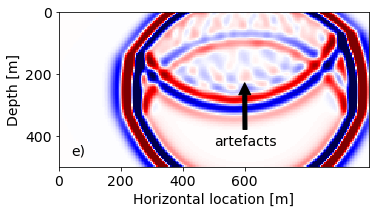

In [13]:
vmin, vmax = (-5e3, 5e3)

it = 20
snap = outputs['slice'][0, it, ...]

fig = plt.figure(facecolor='w', edgecolor='k')
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.02)

ax0 = fig.add_subplot(gs[0, 0])
im0 = ax0.imshow(snap.T, cmap='seismic', vmin=vmin, vmax=vmax, interpolation='none', extent=[0, x[-1], z[-1], 0], aspect=1)
ax0.set_xlabel('Horizontal location [m]')
ax0.set_ylabel('Depth [m]')
ax0.set_xticks(ax0.get_xticks()[:4:])
ax0.set_yticks(ax0.get_yticks()[::2])
ax0.text(40, 460, 'e)')

ax0.annotate('artefacts', xy=(600, 220), xytext=(500, 430),
            arrowprops=dict(facecolor='black', shrink=0.05))

gs.tight_layout(fig)

In [14]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)

Current size: [10.0, 8.0]


In [15]:
awe2d.calc_full?

Object `awe2d.calc_full` not found.


In [16]:
q_src2.loc

NameError: name 'q_src2' is not defined